# Initial tests for classification on the photoswitch dataset


In [77]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pycm import ConfusionMatrix
from sklearn.model_selection import train_test_split

from gpt3forchem.api_wrappers import extract_prediction, fine_tune, query_gpt3
from gpt3forchem.baselines import GPRBaseline, compute_fragprints
from gpt3forchem.data import get_photoswitch_data
from gpt3forchem.input import create_single_property_forward_prompts

plt.style.use(["science", "nature"])

In [5]:
data = get_photoswitch_data()


In [7]:
prompts = create_single_property_forward_prompts(
    data,
    "wavelength_cat",
    {"wavelength_cat": "transition wavelength"},
    representation_col="SMILES",
)


In [8]:
train_prompts, test_prompts = train_test_split(
    prompts, test_size=0.2, random_state=None
)


In [10]:
train_prompts


,prompt,completion
3,what is the transition wavelength of C[N]1C=C(...,0@@@
332,what is the transition wavelength of Cc1[nH]c2...,1@@@
289,what is the transition wavelength of OCCN(CCO)...,1@@@
363,what is the transition wavelength of COC(C=C4)...,1@@@
247,what is the transition wavelength of CC(C=C(N(...,2@@@
...,...,...
135,what is the transition wavelength of CC1=CC=CC...,0@@@
50,what is the transition wavelength of O=C(COC1=...,0@@@
219,what is the transition wavelength of [H]C1=CC(...,3@@@
281,what is the transition wavelength of CC(O)C1=C...,1@@@


In [42]:
train_size = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = (
    f"run_files/{filename_base}_train_prompts_photoswitch_{train_size}.jsonl"
)
valid_filename = (
    f"run_files/{filename_base}_valid_prompts_photoswitch_{test_size}.jsonl"
)

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)
train_size = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = (
    f"run_files/{filename_base}_train_prompts_photoswitch_{train_size}.jsonl"
)
valid_filename = (
    f"run_files/{filename_base}_valid_prompts_photoswitch_{test_size}.jsonl"
)

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)


In [14]:
fine_tune(train_filename, valid_filename, "ada")


wandb: Currently logged in as: kjappelbaum. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.13.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.13.1
wandb: Run data is saved locally in /Users/kevinmaikjablonka/git/kjappelbaum/gpt3forchem/experiments/wandb/run-20220831_112133-ft-ZTxafJhLHFoI8mc5JUlWiiWo
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-ZTxafJhLHFoI8mc5JUlWiiWo
wandb: ⭐️ View project at https://wandb.ai/kjappelbaum/GPT-3
wandb: 🚀 View run at https://wandb.ai/kjappelbaum/GPT-3/runs/ft-ZTxafJhLHFoI8mc5JUlWiiWo
wandb: Waiting for W&B process to finish... (success).
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:             elapsed_examples ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:               elapsed_tokens ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                training_loss 

🎉 wandb sync completed successfully


'ada:ft-lsmoepfl-2022-08-31-09-21-23'

In [16]:
completions = query_gpt3("ada:ft-lsmoepfl-2022-08-31-09-21-23", test_prompts)


In [31]:
predictions = [
    int(extract_prediction(completions, i)) for i in range(len(completions["choices"]))
]


In [35]:
true = [int(e.split("@")[0]) for e in test_prompts["completion"]]


In [38]:
cm = ConfusionMatrix(true, predictions)


In [39]:
print(cm)


Predict  0        1        2        3        4        
Actual
0        21       5        0        0        0        

1        4        15       3        0        0        

2        0        3        20       0        0        

3        0        0        1        4        2        

4        0        0        0        1        0        





Overall Statistics : 

95% CI                                                            (0.66525,0.85374)
ACC Macro                                                         0.9038
ARI                                                               0.50551
AUNP                                                              0.83661
AUNU                                                              0.76037
Bangdiwala B                                                      0.62006
Bennett S                                                         0.69937
CBA                                                               0.57293
CSI                           

## GPR baseline


For the baseline, we will train the GPR in regression mode and then bin the predictions to compute classification scores.


In [7]:
train_frame = pd.read_json(
    "run_files/2022-08-31-11-17-10_train_prompts_photoswitch_313.jsonl",
    orient="records",
    lines=True,
)
test_frame = pd.read_json(
    "run_files/2022-08-31-11-17-10_valid_prompts_photoswitch_79.jsonl",
    orient="records",
    lines=True,
)


In [8]:
train_frame


,prompt,completion
0,what is the transition wavelength of C[N]1C=C(...,0@@@
1,what is the transition wavelength of Cc1[nH]c2...,1@@@
2,what is the transition wavelength of OCCN(CCO)...,1@@@
3,what is the transition wavelength of COC(C=C4)...,1@@@
4,what is the transition wavelength of CC(C=C(N(...,2@@@
...,...,...
308,what is the transition wavelength of CC1=CC=CC...,0@@@
309,what is the transition wavelength of O=C(COC1=...,0@@@
310,what is the transition wavelength of [H]C1=CC(...,3@@@
311,what is the transition wavelength of CC(O)C1=C...,1@@@


Of course, we now have to retrieve the corresponding wavelengths ...


In [14]:
df = get_photoswitch_data()


In [27]:
smiles_train = [
    row.prompt.replace("what is the transition wavelength of", "")
    .replace("###", "")
    .strip()
    for i, row in train_frame.iterrows()
]

smiles_test = [
    row.prompt.replace("what is the transition wavelength of", "")
    .replace("###", "")
    .strip()
    for i, row in test_frame.iterrows()
]


In [35]:
[
    df[df["SMILES"] == smile]["E isomer pi-pi* wavelength in nm"].values[0]
    for smile in smiles_train
]


[325.0,
 392.0,
 407.0,
 399.0,
 417.0,
 328.0,
 402.0,
 310.0,
 307.0,
 322.0,
 320.0,
 592.0,
 368.0,
 323.0,
 403.0,
 378.0,
 332.0,
 436.0,
 337.0,
 321.0,
 391.0,
 335.0,
 489.0,
 399.0,
 415.0,
 394.0,
 491.0,
 305.0,
 325.0,
 432.0,
 402.0,
 401.0,
 362.0,
 335.0,
 408.0,
 318.0,
 483.0,
 396.0,
 336.0,
 410.0,
 327.0,
 385.0,
 323.0,
 328.0,
 443.0,
 413.0,
 440.0,
 387.0,
 395.0,
 545.0,
 475.0,
 515.0,
 321.0,
 312.0,
 468.0,
 421.0,
 488.0,
 397.0,
 323.0,
 565.0,
 399.0,
 400.0,
 346.0,
 317.0,
 310.0,
 526.0,
 412.0,
 378.0,
 390.0,
 333.0,
 404.0,
 362.0,
 555.0,
 392.0,
 461.0,
 414.0,
 342.0,
 302.0,
 328.0,
 329.0,
 623.0,
 350.0,
 416.0,
 400.0,
 400.0,
 482.0,
 363.0,
 400.0,
 325.0,
 384.0,
 455.0,
 332.0,
 346.0,
 340.0,
 320.0,
 395.0,
 403.0,
 412.0,
 451.0,
 446.0,
 371.0,
 413.0,
 311.0,
 340.0,
 338.0,
 316.0,
 350.0,
 404.0,
 336.0,
 345.0,
 411.0,
 448.0,
 362.0,
 398.0,
 406.0,
 364.0,
 432.0,
 380.0,
 342.0,
 330.0,
 330.0,
 428.0,
 325.0,
 441.0,
 395.0,


In [36]:
y_train = np.array(
    [
        df[df["SMILES"] == smile]["E isomer pi-pi* wavelength in nm"].values[0]
        for smile in smiles_train
    ]
)
y_test = np.array(
    [
        df[df["SMILES"] == smile]["E isomer pi-pi* wavelength in nm"].values[0]
        for smile in smiles_test
    ]
)


In [29]:
X_train = compute_fragprints(smiles_train)
X_test = compute_fragprints(smiles_test)


In [37]:
baseline = GPRBaseline()
baseline.fit(X_train, y_train)


/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2022-08-31 13:37:53.129345: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ ()      │ float64 │  0.08347 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 40.9416  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  0.02885 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════

In [38]:
predictions = baseline.predict(X_test)


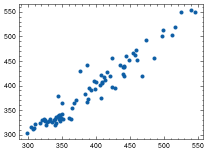

In [40]:
plt.scatter(predictions, y_test)


In [43]:
_, bins = pd.cut(df["E isomer pi-pi* wavelength in nm"], 5, retbins=True)


In [48]:
predicted_bins = pd.cut(predictions.flatten(), bins, labels=np.arange(5))


In [49]:
true_bins = pd.cut(y_test.flatten(), bins, labels=np.arange(5))


In [54]:
cm = ConfusionMatrix(true_bins.astype(int), predicted_bins.astype(int))


In [55]:
print(cm)


Predict  0        1        2        3        4        
Actual
0        16       10       0        0        0        

1        0        20       2        0        0        

2        0        4        18       1        0        

3        0        0        1        6        0        

4        0        0        0        1        0        





Overall Statistics : 

95% CI                                                            (0.66525,0.85374)
ACC Macro                                                         0.9038
ARI                                                               0.45049
AUNP                                                              0.83652
AUNU                                                              0.78373
Bangdiwala B                                                      0.59659
Bennett S                                                         0.69937
CBA                                                               0.54725
CSI                           

But, we have a bit too much boilerplate involved here for training the baseline. Will also move this into one function.


In [57]:
from gpt3forchem.baselines import train_test_gpr_baseline


In [59]:
gpr_results = train_test_gpr_baseline(
    "run_files/2022-08-31-11-17-10_train_prompts_photoswitch_313.jsonl",
    "run_files/2022-08-31-11-17-10_valid_prompts_photoswitch_79.jsonl",
)


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ ()      │ float64 │  0.08347 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 40.9416  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  0.02885 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════

In [61]:
print(gpr_results['cm'])

Predict  0        1        2        3        4        
Actual
0        16       10       0        0        0        

1        0        20       2        0        0        

2        0        4        18       1        0        

3        0        0        1        6        0        

4        0        0        0        1        0        





Overall Statistics : 

95% CI                                                            (0.66525,0.85374)
ACC Macro                                                         0.9038
ARI                                                               0.45049
AUNP                                                              0.83652
AUNU                                                              0.78373
Bangdiwala B                                                      0.59659
Bennett S                                                         0.69937
CBA                                                               0.54725
CSI                           

### Try different representation

Just out of curiosity, let's also try using the chemical name directly in this notebook.

In [63]:
data.dropna(subset=["name"], inplace=True)

In [64]:
prompts = create_single_property_forward_prompts(
    data,
    "wavelength_cat",
    {"wavelength_cat": "transition wavelength"},
    representation_col="name",
)


In [65]:
prompts

,prompt,completion
0,what is the transition wavelength of phenyl-(1...,0@@@
1,what is the transition wavelength of (1-methyl...,1@@@
2,what is the transition wavelength of bis(2-flu...,0@@@
3,"what is the transition wavelength of bis(2,4,6...",0@@@
4,"what is the transition wavelength of bis(2,3,5...",0@@@
...,...,...
83,what is the transition wavelength of N-ethyl-4...,2@@@
84,what is the transition wavelength of 2-[[4-(4-...,2@@@
85,what is the transition wavelength of (E)-bis(1...,2@@@
86,"what is the transition wavelength of 1,3-benzo...",0@@@


In [66]:
train_prompts, test_prompts = train_test_split(prompts, test_size=0.2, random_state=None)

In [67]:
train_size = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = (
    f"run_files/{filename_base}_train_prompts_photoswitch_{train_size}.jsonl"
)
valid_filename = (
    f"run_files/{filename_base}_valid_prompts_photoswitch_{test_size}.jsonl"
)

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)


In [68]:
print(train_size, test_size)

70 18


In [69]:
fine_tune(train_filename, valid_filename, "ada")

wandb: Currently logged in as: kjappelbaum. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.13.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.13.1
wandb: Run data is saved locally in /Users/kevinmaikjablonka/git/kjappelbaum/gpt3forchem/experiments/wandb/run-20220831_140905-ft-WUboDYp7grSDU5x0Nf1FGBMr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-WUboDYp7grSDU5x0Nf1FGBMr
wandb: ⭐️ View project at https://wandb.ai/kjappelbaum/GPT-3
wandb: 🚀 View run at https://wandb.ai/kjappelbaum/GPT-3/runs/ft-WUboDYp7grSDU5x0Nf1FGBMr
wandb: Waiting for W&B process to finish... (success).
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:             elapsed_examples ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:               elapsed_tokens ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:                training_loss 

🎉 wandb sync completed successfully


'ada:ft-lsmoepfl-2022-08-31-12-08-57'

In [70]:
completions = query_gpt3('ada:ft-lsmoepfl-2022-08-31-12-08-57', test_prompts)

predictions = [
    int(extract_prediction(completions, i)) for i in range(len(completions["choices"]))
]

true = [int(e.split("@")[0]) for e in test_prompts["completion"]]

cm = ConfusionMatrix(true, predictions)


In [71]:
print(cm)

Predict  0        1        2        3        
Actual
0        10       0        1        0        

1        1        0        2        0        

2        0        0        1        0        

3        0        0        3        0        





Overall Statistics : 

95% CI                                                            (0.3859,0.83632)
ACC Macro                                                         0.80556
ARI                                                               0.48952
AUNP                                                              0.7521
AUNU                                                              0.67666
Bangdiwala B                                                      0.78906
Bennett S                                                         0.48148
CBA                                                               0.26299
CSI                                                               None
Chi-Squared                                                  

In [89]:
print(cm.F1_Macro, cm.F1_Micro)

0.2897727272727273 0.6111111111111112


In [79]:
gpr_results = train_test_gpr_baseline(train_filename, valid_filename, representation_column="name")

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ ()      │ float64 │ -0.07402 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 41.3316  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  0.08544 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════

In [81]:
print(gpr_results['cm'])

Predict 0       1       2       3       
Actual
0       8       3       0       0       

1       1       2       0       0       

2       0       1       0       0       

3       0       0       2       1       





Overall Statistics : 

95% CI                                                            (0.3859,0.83632)
ACC Macro                                                         0.80556
ARI                                                               0.34299
AUNP                                                              0.73641
AUNU                                                              0.65001
Bangdiwala B                                                      0.56557
Bennett S                                                         0.48148
CBA                                                               0.34848
CSI                                                               -0.01263
Chi-Squared                                                       21.75758
Chi-Sq

In [88]:
print(gpr_results['cm'].F1_Macro, gpr_results['cm'].F1_Micro)

0.4361111111111111 0.6111111111111112


Here, the GPR seems to do better.

### Now try SELFIES before we debug the learning curve script.

In [101]:
data = get_photoswitch_data()
prompts = create_single_property_forward_prompts(
    data,
    "wavelength_cat",
    {"wavelength_cat": "transition wavelength"},
    representation_col="selfies",
)
train_prompts, test_prompts = train_test_split(
    prompts, test_size=0.8, random_state=None
)

train_size = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = (
    f"run_files/{filename_base}_train_prompts_photoswitch_{train_size}.jsonl"
)
valid_filename = (
    f"run_files/{filename_base}_valid_prompts_photoswitch_{test_size}.jsonl"
)

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)
train_size = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = (
    f"run_files/{filename_base}_train_prompts_photoswitch_{train_size}.jsonl"
)
valid_filename = (
    f"run_files/{filename_base}_valid_prompts_photoswitch_{test_size}.jsonl"
)

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)



fine_tune(train_filename, valid_filename, "ada")



wandb: Currently logged in as: kjappelbaum. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.13.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.13.1
wandb: Run data is saved locally in /Users/kevinmaikjablonka/git/kjappelbaum/gpt3forchem/experiments/wandb/run-20220831_152656-ft-tMaOO5fT4Y8mfa1Q6KOhmuP8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-tMaOO5fT4Y8mfa1Q6KOhmuP8
wandb: ⭐️ View project at https://wandb.ai/kjappelbaum/GPT-3
wandb: 🚀 View run at https://wandb.ai/kjappelbaum/GPT-3/runs/ft-tMaOO5fT4Y8mfa1Q6KOhmuP8
wandb: Waiting for W&B process to finish... (success).
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:             elapsed_examples ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:               elapsed_tokens ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:                training_loss 

🎉 wandb sync completed successfully


'ada:ft-lsmoepfl-2022-08-31-13-26-47'

In [103]:
completions = query_gpt3('ada:ft-lsmoepfl-2022-08-31-13-26-47', test_prompts)

predictions = [
    int(extract_prediction(completions, i)) for i in range(len(completions["choices"]))
]

true = [int(e.split("@")[0]) for e in test_prompts["completion"]]

cm = ConfusionMatrix(true, predictions)


In [106]:
print(cm)

Predict  0        1        2        3        4        
Actual
0        55       43       13       0        0        

1        17       60       15       0        0        

2        4        40       35       1        0        

3        0        2        9        12       0        

4        0        0        1        7        0        





Overall Statistics : 

95% CI                                                            (0.46065,0.5712)
ACC Macro                                                         0.80637
ARI                                                               0.14213
AUNP                                                              0.66189
AUNU                                                              0.64307
Bangdiwala B                                                      0.28473
Bennett S                                                         0.3949
CBA                                                               0.37371
CSI                            

In [116]:
gpr_results = train_test_gpr_baseline(train_filename, valid_filename, representation_column="selfies")

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ ()      │ float64 │ -3.81799 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 31.8811  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  0.12663 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════

In [117]:
print(gpr_results['cm'])

Predict  0        1        2        3        4        
Actual
0        49       58       4        0        0        

1        4        60       27       1        0        

2        0        21       56       3        0        

3        0        0        6        17       0        

4        0        0        0        7        1        





Overall Statistics : 

95% CI                                                            (0.52826,0.63734)
ACC Macro                                                         0.83312
ARI                                                               0.24444
AUNP                                                              0.71426
AUNU                                                              0.70863
Bangdiwala B                                                      0.35224
Bennett S                                                         0.4785
CBA                                                               0.44148
CSI                           